In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

from spiker import *
from rnn import rnn

In [34]:
# https://www.mathworks.com/help/ident/ref/goodnessoffit.html
def goodness_of_fit(ann_states, snn_states):
    nmse_layers = []
    epsilon = 1e-18
    layers = range(len(ann_states))
    transient = 0
    for idx in layers: # layer idx
        dims = ann_states[idx].shape[0]
        nmse = []
        for jdx in range(dims):
            ref = ann_states[idx][jdx,transient:]
            y = snn_states[idx][jdx,transient:]
            diff = ref - y
            num = np.sum(diff*diff)
            ref_ch_mean = np.mean(ref)
            ref_diff = ref - ref_ch_mean #+ epsilon
            den = np.sum(ref_diff*ref_diff)
            if (den < epsilon) | (num < epsilon):
                if num < den:
                    nmse += [1]
                elif den > epsilon: # ignore for small den=0
                    nmse += [1 - num/den]
            else:
                nmse += [1 - (num/den)]
        nmse_layer = np.mean(nmse)
        print(f'MSE in layer {idx} is {nmse_layer:.3f}')
        nmse_layers += [nmse_layer]
    return nmse_layers
goodness_of_fit(ann_states, snn_states)

MSE in layer 0 is 1.000
MSE in layer 1 is -12.496
MSE in layer 2 is -0.488
MSE in layer 3 is -0.310
MSE in layer 4 is -0.157
MSE in layer 5 is -1.726
MSE in layer 6 is -0.128
MSE in layer 7 is -0.127
MSE in layer 8 is -0.417


[1.0,
 -12.496051212367842,
 -0.4876519175272214,
 -0.3097162851491235,
 -0.15663898689951217,
 -1.7262973073269636,
 -0.12798075498372702,
 -0.12666151081592966,
 -0.41736322083556227]

In [3]:
def compare_activations(net, ann_states, snn_states, label='', plot=True, axis='off'):
    plt.rcParams['lines.linewidth'] = 1.2
    import matplotlib.patches as mpatches
    # Plotting and visualization
    print('Pole frequency = {0:.3f} Hz'.format(1/net.tau))
    goodness = goodness_of_fit(ann_states, snn_states)
    if plot:
        for idx in range(len(ann_states)): # layer idx
            dims = ann_states[idx].shape[0]
            if dims >= 3:
                cols = 3
            else:
                cols=dims
            rows = int(np.ceil(dims/cols))
            fig, axs = plt.subplots(rows,cols)
            for jdx in range(ann_states[idx].shape[0]): # dim idx
                ax = plt.subplot(rows,cols,jdx+1)
                plt.plot(tsteps, ann_states[idx][jdx,:], color='r', linestyle='-.', label=f'ANN - Layer {idx}')
                plt.plot(tsteps, snn_states[idx][jdx,:], color='g', alpha=0.7, label=f'SNN - Layer {idx}')
                plt.axis(axis)
                plt.subplots_adjust(wspace=0, hspace=0)

            label_ext = label+f' NMSE = {goodness[idx]:.4f}.'

            if idx == 0:
                fig.suptitle(f'Input dense layer.'+label_ext, fontsize=12)
            elif idx == len(ann_states)-1:
                fig.suptitle(f'Output dense layer.'+label_ext, fontsize=12)
            elif idx%2 == 1:
                fig.suptitle(f'Recurrent layer {int(np.floor((idx+1)/2))}.'+label_ext, fontsize=12)
            else:
                fig.suptitle(f'Dense layer {int(np.floor((idx)/2))}.'+label_ext, fontsize=12)
            patch1 = mpatches.Patch(color='r', label='ANN output')
            patch2 = mpatches.Patch(color='g', label='SNN output')
            fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
            fig.legend(handles=[patch1, patch2], loc='lower center', fancybox=True, shadow=True, fontsize=12, ncol=2)
            plt.savefig(f'./img/ANN-RNN-Layer-{idx}-{label}.png', dpi=300)
    t = 0
    for N in net.neurons:
        t += np.sum(N.spike_count)
    print('Average spike rate = {0:.3f} KHz'. format(1e-3*t/(tsteps[-1]*op_dim+res_dim+ip_dim)))

In [4]:
def plot_activations(net, rnn_states, label='', plot=True, axis='off'):
    for idx in range(len(ann_states)): # layer idx
        dims = ann_states[idx].shape[0]
        if dims >= 3:
            cols = 3
        else:
            cols=dims
        rows = int(np.ceil(dims/cols))
        fig, axs = plt.subplots(rows,cols)
        for jdx in range(ann_states[idx].shape[0]): # dim idx
            ax = plt.subplot(rows,cols,jdx+1)
            plt.plot(tsteps, rnn_states[idx][jdx,:], color='r', linestyle='-.', label=f'ANN - Layer {idx}')
            plt.axis(axis)
            plt.subplots_adjust(wspace=0, hspace=0)

        label_ext = r' $c_{v_p} = $'+label

        if idx == 0:
            fig.suptitle(f'Input dense layer.'+label_ext, fontsize=12)
        elif idx == len(ann_states)-1:
            fig.suptitle(f'Output dense layer.'+label_ext, fontsize=12)
        elif idx%2 == 1:
            fig.suptitle(f'Recurrent layer {int(np.floor((idx+1)/2))}.'+label_ext, fontsize=12)
        else:
            fig.suptitle(f'Dense layer {int(np.floor((idx)/2))}.'+label_ext, fontsize=12)
        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
    t = 0
    for N in net.neurons:
        t += np.sum(N.spike_count)
    print('Average spike rate = {0:.3f} KHz'. format(1e-3*t/(tsteps[-1]*op_dim+res_dim+ip_dim)))

In [5]:
# Generate simulation data
def gen_data(nblocks,f1,f2, tstart=0, tstop=0.0001, Ts=1e-6,amp=1e-8):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    #np.random.seed(1)
    tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
    time = tseries.time
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+1*np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 1*np.sin(2*np.pi*timeblock*f2)+2*np.sin(2*np.pi*timeblock*f1)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op, time

In [6]:
def run_rnn(net, ip, mode='ann'):
    rnn_states = net.rnn_forward(ip, mode=mode)
    return rnn_states
def run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams, net=None):
    if net is None:
        net = rnn(nrlayers, ip_dim, res_dim, op_dim, nparams=nparams)
    ann_states = run_rnn(net, ip, mode = 'ann')
    snn_states = run_rnn(net, ip, mode = 'snn')
    return ann_states, snn_states, net

In [7]:
def gen_input(tstop, Ts_ann, Ts_snn):
    ip1,_,tsteps = gen_data(nblocks=2, f1=4, f2=15, tstop=tstop, Ts=Ts_ann)
    ip2,_,tsteps = gen_data(nblocks=1, f1=4, f2=15, tstop=tstop, Ts=Ts_ann)
    inp1 = Tseries(ip1, tsteps)
    inp2 = Tseries(ip2, tsteps)
    inp1.plot(label = "Input pattern")
    inp2.plot(label = "Input pattern")
    ip = np.stack((ip1,ip2))
    print('Sequence length is {}'.format(ip.shape[1]))
    return ip, tsteps

Sequence length is 20000
Pole frequency = 676.930 Hz
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 1.000
MSE in layer 3 is -2.109
MSE in layer 4 is 1.000
MSE in layer 5 is 0.972
MSE in layer 6 is 0.997
MSE in layer 7 is -178262.294
MSE in layer 8 is 0.985
Average spike rate = 270.107 KHz


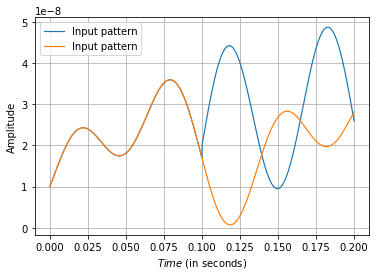

In [17]:
# Experimental test case
# Generate input
tstop  = 0.2
Ts_ann = 1e-5 # resolution of ANN
Ts_snn = 1e-6 # resolution of SNN
ip, tsteps = gen_input(tstop, Ts_ann, Ts_snn)

# Network params
ip_dim = ip.shape[0]
op_dim = 3
res_dim = 51
nrlayers = 4
seq_len = ip.shape[1]
nparams = {}

# SNN settings
nparams = {}
nparams['Ts_ann'] = Ts_ann
nparams['Ts']     = Ts_snn

# Run ANN with low resolution specs.
net = rnn(nrlayers, ip_dim, res_dim, op_dim, nparams=nparams)
ann_states = run_rnn(net, ip, mode='ann')


# Then run SNN with high resolution specs.
# first upsample the input
ip_snn = resample(ip, int(tstop/Ts_snn), axis=1)
snn_states = run_rnn(net, ip_snn, mode='snn')
# Resample for plotting
for idx in range(len(snn_states)):
    snn_states[idx] = resample(snn_states[idx], int(tstop/Ts_ann), axis=1)

# compare ann and snn activations
compare_activations(net, ann_states, snn_states, label='low_Ts', plot=False, axis='Off')

In [ ]:
# Test case to study effect of different sampling
op_dim = 3
res_dim = 51
nrlayers = 4
tstop  = 0.2
Ts_snn = 1e-6 # resolution of SNN
nparams = {}
nmse_avgs = {}
nmse_stds = {}
nruns = 200
Ts_ann_list = [1e-5, 1e-4, 1e-3, 5e-2, 1e-2]
Ts_ann_list = [5e-2]
for Ts_ann in Ts_ann_list:
    print('='*89)
    print(f'Running {nruns} tests with Ts_ann = {Ts_ann}')
    nmse_runs = []
    
    # Generate input
    Ts_ann = Ts_ann # resolution of ANN
    ip, tsteps = gen_input(tstop, Ts_ann, Ts_snn)
    ip_dim = ip.shape[0]
    seq_len = ip.shape[1]
    
    nparams['Ts_ann'] = Ts_ann
    for _ in range(nruns):
        print(f'Test #{_+1}/{nruns}'+'-'*10)
        # Run ANN with low resolution specs.
        net = rnn(nrlayers, ip_dim, res_dim, op_dim, nparams=nparams)
        ann_states = run_rnn(net, ip, mode='ann')

        # Then run SNN with high resolution specs.
        # first upsample the input
        ip_snn = resample(ip, int(tstop/Ts_snn), axis=1)
        snn_states = run_rnn(net, ip_snn, mode='snn')

        # Resample for comparison
        for idx in range(len(snn_states)):
            snn_states[idx] = resample(snn_states[idx], int(tstop/Ts_ann), axis=1)    

        nmse_runs += [goodness_of_fit(ann_states, snn_states)]
    nmse_runs = np.array(nmse_runs)
    nmse_avgs[r'Len '+f' = {seq_len}'] = np.mean(nmse_runs, axis=0)
    nmse_stds[r'Len '+f' = {seq_len}']  = np.std(nmse_runs, axis=0)
#     plt.semilogy(range(len(ann_states)), nmse_avgs[mismatch], label = f'Mismatch std = {mismatch}')
nmse_avgs = pd.DataFrame.from_dict(nmse_avgs)
nmse_stds = pd.DataFrame.from_dict(nmse_stds) 
results = (nmse_avgs, nmse_stds)
with open(f'./img/mapping_oversampling_r{res_dim}.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running 200 tests with Ts_ann = 0.05
Sequence length is 4
Test #1/200----------


In [36]:
with open(f'./img/mapping_oversampling_r{res_dim}.pickle', 'rb') as handle:
    nmse_avgs, nmse_stds = pickle.load(handle)

In [37]:
label = []
for idx in range(2*nrlayers+1):
    if idx == 0:
        label += [f'Input dense layer']
    elif idx == len(ann_states)-1:
        label += [f'Output dense layer']
    elif idx%2 == 1:
        label += [f'Recurrent layer {int(np.floor((idx+1)/2))}']
    else:
        label += [f'Dense layer {int(np.floor((idx)/2))}']

def dump_df(df, label):
    layer_names = df['Layer'].values
    indices = df.index.values.tolist()
    df.T.columns = layer_names
    df = df.set_index('Layer')
    with open(f'./img/osr_sims_{label}.tex', 'w') as tf:
         tf.write(df.to_latex(escape=False, float_format=lambda x: '%.1f' % x))
    return df

In [38]:
nmse_stds['Layer'] = label
nmse_avgs['Layer'] = label
nmse_avgs.set_index('Layer')
nmse_stds.set_index('Layer')
avg_df = dump_df(nmse_avgs, "avg")
std_df = dump_df(nmse_stds, "std")
merged_df = pd.concat([avg_df.T, std_df.T], keys=['Mean', 'Std']).T
merged_df ['Layer'] = label
merged_df = dump_df(merged_df, f'{res_dim}')
merged_df

Mean                                           Std  \
                   Len  = 20000 Len  = 2000 Len  = 200 Len  = 20 Len  = 20000   
Layer                                                                           
Input dense layer      1.000000    1.000000   1.000000  1.000000     0.000000   
Recurrent layer 1      0.982303    0.991210   0.806407 -0.619427     0.029725   
Dense layer 1          0.996564    0.996332   0.937244 -0.162356     0.004581   
Recurrent layer 2      0.967518    0.980989   0.761589 -1.298273     0.078561   
Dense layer 2          0.993505    0.993620   0.906172 -0.347099     0.006037   
Recurrent layer 3      0.940444    0.970109   0.599705 -1.400507     0.181879   
Dense layer 3          0.988332    0.989336   0.871917 -0.487388     0.009739   
Recurrent layer 4      0.915443    0.949494   0.173001 -2.139720     0.312062   
Output dense layer     0.980581    0.982224   0.825342 -0.620602     0.013617   

                                                     
                   Len  = 2000 Len  = 200 Len  = 20  
Layer                                                
Input dense layer     0.000000   0.000000  0.000000  
Recurrent layer 1     0.007726   0.603780  1.388686  
Dense layer 1         0.002773   0.080508  0.387804  
Recurrent layer 2     0.015723   0.476619  3.498054  
Dense layer 2         0.004174   0.083065  0.287151  
Recurrent layer 3     0.033467   0.888476  4.804045  
Dense layer 3         0.005987   0.096241  0.276396  
Recurrent layer 4     0.078121   5.413960  5.173430  
Output dense layer    0.010786   0.110505  0.496689